_Version log: Branch of V19. Trying out a new way of boundry checking and randomising the samples_

In [48]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [49]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

In [50]:
file_name = "1dmockanderrors1"
file_type = ".csv"

target, uncertainties = open_dataset(file_name, file_type)
total_points = len(target)

In [51]:
iterations = 5000
max_temp = 31
cooling = 0.998
subsample_percentage = 0.05
regularization_coeffient = 1e-4 # DECREASE FOR 'COMPLEX' IMAGES (up to 1e-7) INCREASE FOR 'SIMPLE' IMAGES (up to 1e-2)
min_seperation = 1

reduced_points = round(total_points *subsample_percentage)
detectors = original_detectors = subsample_1d(total_points, subsample_percentage, "regular")

print(total_points, reduced_points)

400 20


In [52]:
#########INITAILISATION##########

scores = np.array([])
temps = []

result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
score = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########

for n in tqdm(range(iterations)):

    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points

        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]

        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved

    new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)
    new_score = np.linalg.norm((target -new_result) /uncertainties) #This is the chi-squared

    if new_score < score:
        detectors = new_detectors
        result = new_result
        score = new_score
        improvement = True

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

  0%|          | 13/5000 [00:00<01:34, 52.51it/s]

100%|██████████| 5000/5000 [01:47<00:00, 46.51it/s]


In [53]:
frequent_temps = np.array(np.unique(temps[1], return_counts=True)).T
frequent_temps = frequent_temps[frequent_temps[:, 1].argsort()[::-1]]
frequent_temps[:5]

array([[ 17., 824.],
       [ 19., 746.],
       [ 15., 642.],
       [ 21., 470.],
       [ 13., 324.]])

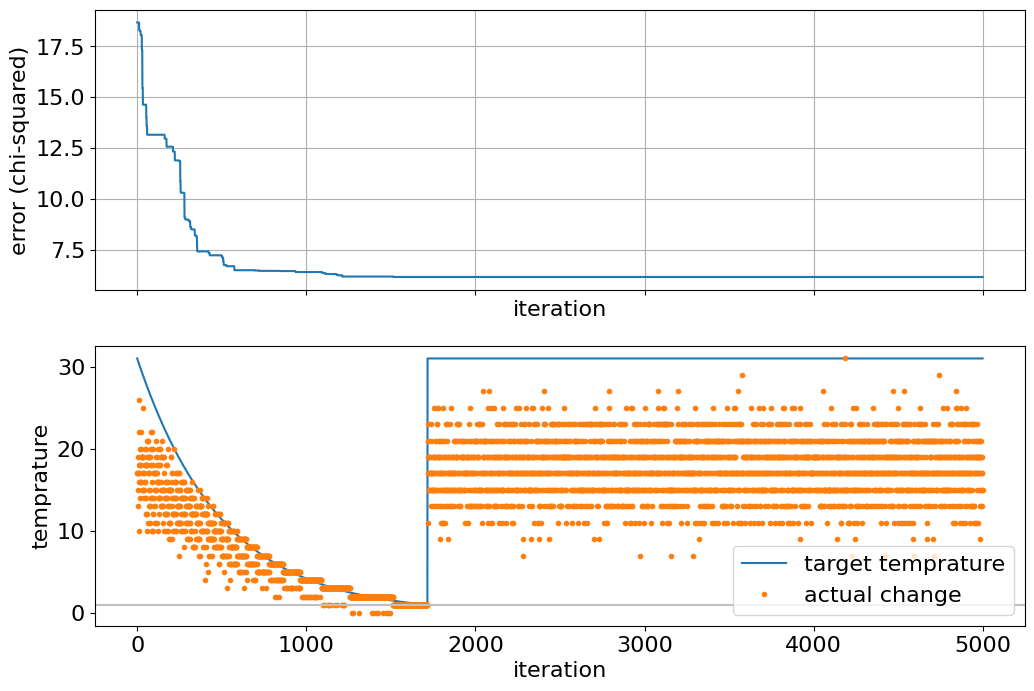

best score = 6.173


In [54]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (chi-squared)", xlabel= "iteration")

axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))

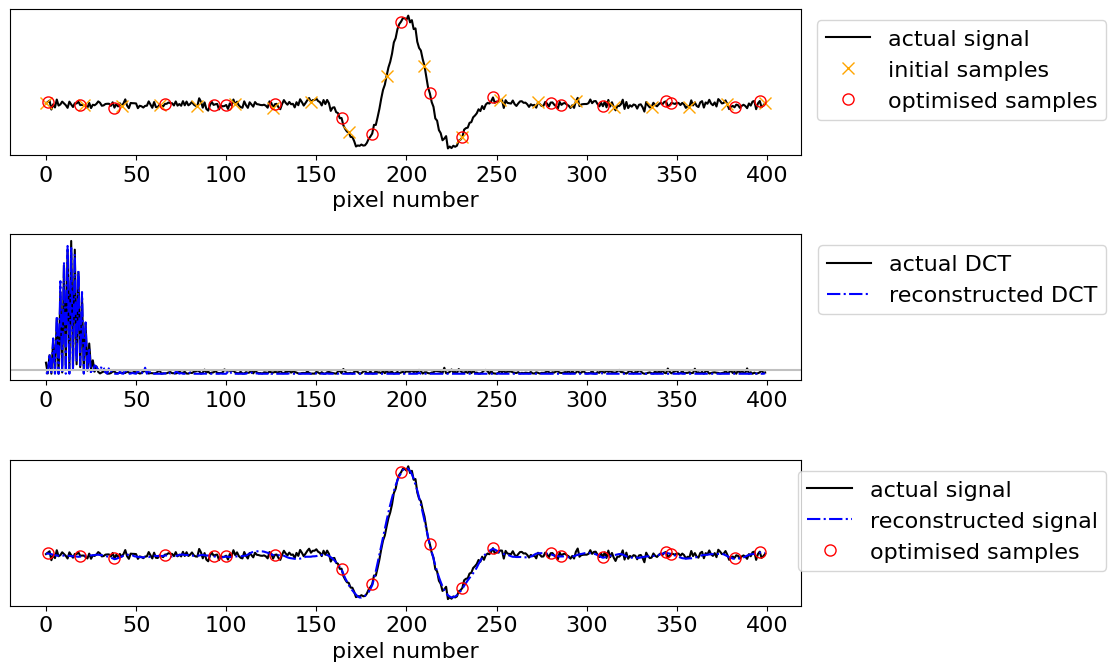

CS used 20 samples out of 62 needed to resolve the interferogram.
CS identified 23 out of 31 significant frequencies.


In [62]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")

threshold = np.abs(target_DCT).mean()

plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(original_detectors, target[original_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")
axs[1].hlines(threshold, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()

print("CS used {0:d} samples out of {1:d} needed to resolve the interferogram.".format(reduced_points, 2*np.count_nonzero(np.abs(target_DCT) > threshold)))
print("CS identified {0:d} out of {1:d} significant frequencies.".format(np.count_nonzero(np.abs(result_DCT) > threshold), np.count_nonzero(np.abs(target_DCT) > threshold)))

In [56]:
optlocs_file = "data\\" + file_name +"_optlocs.csv"

with open(optlocs_file, 'a') as file: #chat gpt did this bit for me.
    # Add data to a new line
    detectors_string = np.array2string(detectors, separator=',').replace('\n', '')[1:-1]
    file.write(detectors_string +"\n")
    file.close()


In [57]:
#I'm surprised that numpy and scipy don't have meathods for reading files with inconsistant numbers of delimiters.

with open(optlocs_file, 'r') as file:
    lines = [line[:-1] for line in list(file)]
    lines = [line for line in lines if line.count(",") == 19] # filter by number of samples
    number_of_delimiters = [line.count(",") for line in lines]
    max_delimiters = max(number_of_delimiters)
    missing_delimiters = [max_delimiters -delimiters for delimiters in number_of_delimiters]
    data = [line.split(",") for line in lines]
    data = [[int(datapoint) for datapoint in line] for line in data] #2D list comprehention!!!!
    full_data = [data[n] + [np.nan]*missing_delimiters[n] for n in range(len(lines))]
    full_data = np.array(full_data)
    file.close()

print(len(lines))

30


In [58]:
frequent_locs = np.array(np.unique(full_data, return_counts=True)).T
full_data = full_data[~np.isnan(full_data)]
frequent_locs = frequent_locs[:-1] #remove nans
frequent_locs = frequent_locs[frequent_locs[:, 1].argsort()[::-1]]
frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else np.nan for n in range(total_points)]
frequent_locs = np.array(frequent_locs)
print("Detector locations: Occurrences")
print(np.array([detectors, frequent_locs[detectors]]).T)

Detector locations: Occurrences
[[  1.   4.]
 [ 19.   1.]
 [ 38.   2.]
 [ 66.   2.]
 [ 93.   2.]
 [100.   2.]
 [127.   2.]
 [164.   2.]
 [181.   4.]
 [197.   1.]
 [213.   2.]
 [231.   1.]
 [248.   2.]
 [280.   2.]
 [286.   2.]
 [309.   3.]
 [344.   1.]
 [347.   2.]
 [382.   3.]
 [396.   1.]]


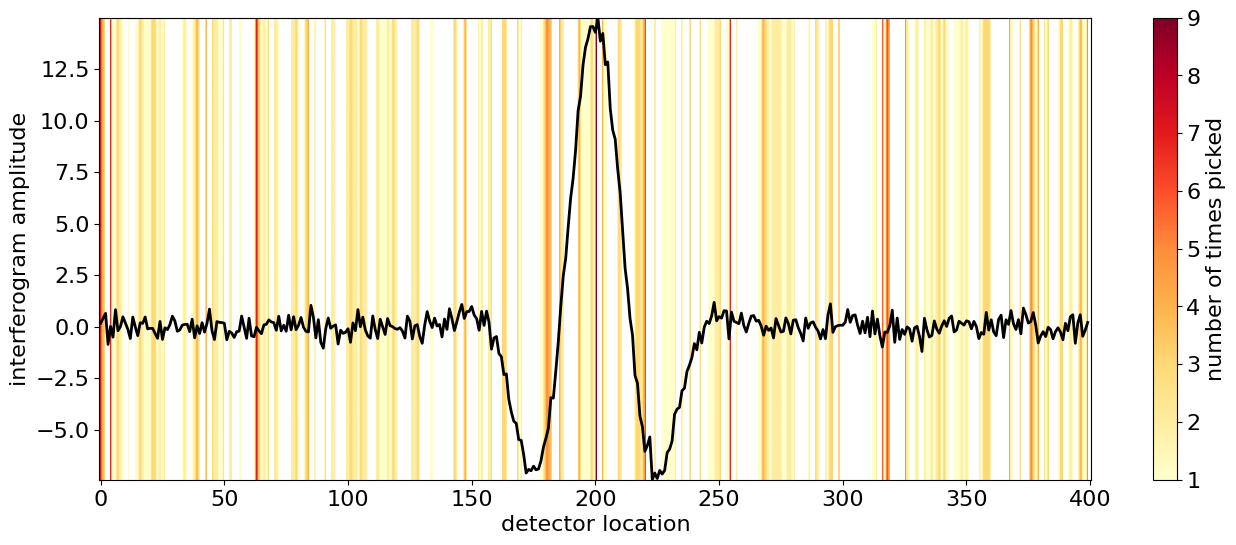

In [59]:
fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")

im = plt.imshow([frequent_locs], aspect= "auto", extent= (-0.5, total_points +0.5, min(target), max(target)), cmap= "YlOrRd")#, norm= "log")
plt.colorbar(im, label= "number of times picked")

axs.set(xlabel= "detector location", ylabel= "interferogram amplitude")
plt.show()

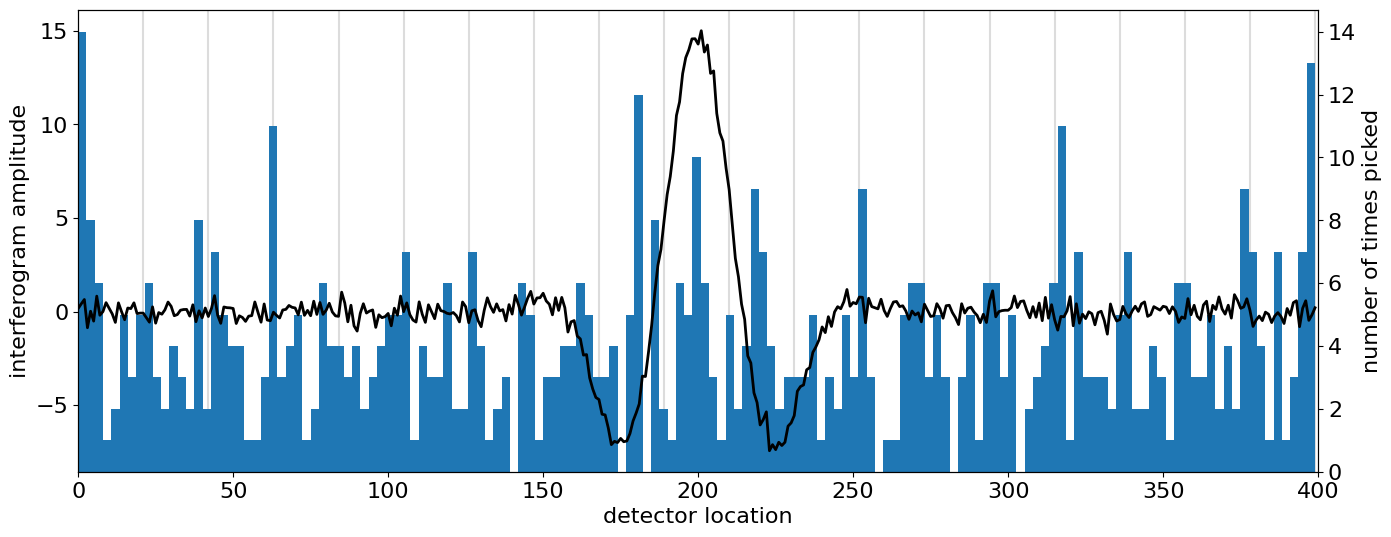

In [64]:
bins = int(total_points//2.67)

fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")
axs.set(xlabel= "detector location", ylabel= "interferogram amplitude", zorder= 2.9, xlim= (0, total_points))
axs.patch.set_visible(False)

twinax = axs.twinx()
#twinax.plot(frequent_locs, linestyle= "None", marker= "x", markersize= 8)
twinax.vlines(original_detectors, ymin= 0, ymax= 1, colors= "gainsboro", transform=twinax.get_xaxis_transform(), zorder= 0.9)
twinax.hist(full_data, bins= bins)
twinax.set(ylabel= "number of times picked")

plt.show()